<a href="https://colab.research.google.com/github/SebastianBentert/example_code/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit

## Get data


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

In [ ]:
def get_lines(filename):
  '''
  Reads filename (text file) and returns the lines of text as list.

  Args:
    filename: a string containing the target filepath

  Return:
    A list of strings with one string per line from filename
  '''
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+'train.txt')
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text(filename):
  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1].lower()
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) -1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples




In [ ]:
train_samples = preprocess_text(data_dir+'train.txt')
val_samples = preprocess_text(data_dir+'dev.txt')
test_samples = preprocess_text(data_dir+'test.txt')


In [ ]:
len(train_samples),len(val_samples),len(test_samples)

(180040, 30212, 30135)

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

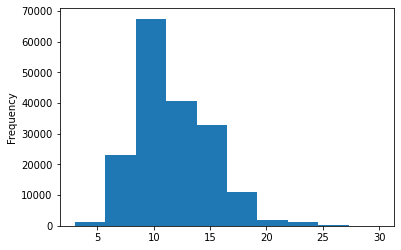

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

## Make numeric labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0 = Pipeline([
  ('tf-idf', TfidfVectorizer()),
  ('clf', MultinomialNB())
])
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
model_0.score(X=val_sentences,y=val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-09-09 19:24:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-09 19:24:32 (76.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing text for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

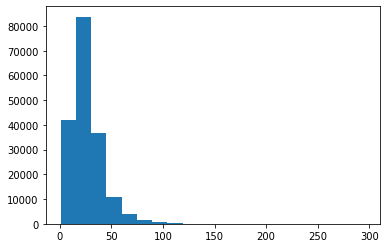

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [ ]:
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
max(sent_lens)

296

### Create text vectorizer layer

In [ ]:
max_token = 68000 #taken from paper

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_token,
                                    output_sequence_length=output_seq_len)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
room-air tcom values ( mean mmhg , @ % confidence interval ( ci ) ) were : lateral leg @ , ci @ to @ ; lateral malleolus @ , ci @ to @ ; medial malleolus @ , ci @ to @ ; dorsum , between first and second toe @ , ci @ to @ ; dorsum , proximal to fifth metatarsal-phalangeal joint @ , ci @ to @ ; plantar @ , ci @ to @ .

Length of text: 80

Vectorized text: [[34731 14387   334    57   694   235   222    50     9  1379  1508    50
      6  1379 14780    50     6  2719 14780    50     6 31625    30   152
      3   480  9812    50     6 31625  1844     6  4957 52641  1060    50
      6  4360    50     6     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print('Number of words in vobac:',len(rct_20k_text_vocab))

Number of words in vobac: 64841


In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True}

### Create custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name='token_embedding')

## Create datasets

In [ ]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D

In [ ]:
inputs = layers.Input(shape=(1,),dtype='string')
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64,kernel_size=5, padding='same',activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(loss='categorical_crossentropy',
                metrics='accuracy')
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

In [ ]:
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs = 3,
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 48ms/step - loss: 0.9561 - accuracy: 0.6198 - val_loss: 0.7277 - val_accuracy: 0.7164
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.6935 - accuracy: 0.7404 - val_loss: 0.6594 - val_accuracy: 0.7527
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.6491 - accuracy: 0.7615 - val_loss: 0.6250 - val_accuracy: 0.7703


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.6320 - accuracy: 0.7732


[0.6320072412490845, 0.7732357978820801]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

(array([[4.2151433e-01, 2.4155098e-01, 5.0462313e-02, 2.6364580e-01,
         2.2826592e-02],
        [4.0235111e-01, 3.3297318e-01, 3.0568256e-03, 2.5841716e-01,
         3.2016598e-03],
        [1.3194428e-01, 1.8183548e-02, 7.1073254e-04, 8.4913570e-01,
         2.5721727e-05],
        ...,
        [1.0814591e-06, 1.0595543e-03, 1.5288607e-03, 7.5650377e-07,
         9.9740976e-01],
        [5.2652493e-02, 5.2034336e-01, 1.2223914e-01, 8.1204377e-02,
         2.2356059e-01],
        [3.5549137e-01, 3.9332059e-01, 6.0193885e-02, 9.8324686e-02,
         9.2669398e-02]], dtype=float32), (30212, 5))

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

In [ ]:
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)
model_1_results

{'accuracy': 77.32358003442341,
 'f1': 0.7700469883482939,
 'precision': 0.7704546934085656,
 'recall': 0.7732358003442341}

## Model 2: Feature extraction with pretrained token embeddings

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [ ]:
random_train_sentence = random.choice(train_sentences)
print(random_train_sentence)
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(use_embedded_sentence, use_embedded_sentence.shape)

In [ ]:
inputs = layers.Input(shape=[],dtype='string')
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=inputs,outputs=outputs,name='model_2')

model_2.compile(loss='categorical_crossentropy',
                metrics='accuracy')

history_2 = model_2.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 0.9159 - accuracy: 0.6518 - val_loss: 0.8006 - val_accuracy: 0.6875
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7714 - accuracy: 0.7001 - val_loss: 0.7539 - val_accuracy: 0.7068
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7566 - accuracy: 0.7093 - val_loss: 0.7366 - val_accuracy: 0.7154


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7414 - accuracy: 0.7144


[0.7414480447769165, 0.7143850326538086]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.45437562, 0.32801878, 0.00209238, 0.20791402, 0.00759922],
       [0.3471333 , 0.48980695, 0.00459138, 0.15464245, 0.00382588],
       [0.20657776, 0.13885234, 0.01322782, 0.6052482 , 0.03609385],
       ...,
       [0.00151358, 0.00483827, 0.07171052, 0.00099047, 0.92094713],
       [0.00314068, 0.0371909 , 0.2501778 , 0.00161051, 0.70788014],
       [0.13301721, 0.22604845, 0.5693169 , 0.00688884, 0.06472855]],
      dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)
model_2_results

{'accuracy': 71.43850125777837,
 'f1': 0.7111799062192959,
 'precision': 0.7153880234210098,
 'recall': 0.7143850125777836}

## Model 3: Conv1D with character embeddings

In [ ]:
def split_chars(text):
  return ' '.join(list(text))

In [ ]:
print(split_chars(random_train_sentence))

t h e   r a n d o m i z e d   c o n t r o l l e d   t r i a l   c o m p o n e n t   o f   t h e   k e s h o   b o r a   s t u d y   w a s   r e g i s t e r e d   a t   c u r r e n t   c o n t r o l l e d   t r i a l s   (   w w w . c o n t r o l l e d - t r i a l s . c o m   )   a s   i s r c t n @   .


In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <a list of 10 Patch objects>)

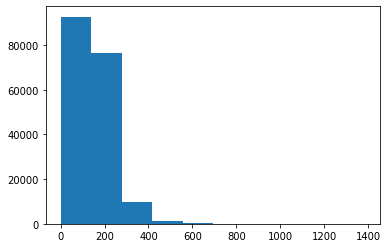

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=10)

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
import  string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [ ]:
NUM_CHAR_TOKENS = len(alphabet)+2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name='char_vectorizer')

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab)

28

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name='char_embed')

In [ ]:
inputs = layers.Input(shape=(1,),dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5,padding='same',activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_3')
model_3.compile(loss='categorical_crossentropy',
                metrics='accuracy')
model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           700       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
history_3 = model_3.fit(train_char_dataset,
                        steps_per_epoch=int(0.1*len(train_char_dataset)),
                        epochs=3,
                        validation_data=val_char_dataset,
                        validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 38s 66ms/step - loss: 1.2637 - accuracy: 0.4819 - val_loss: 1.1221 - val_accuracy: 0.5376
Epoch 2/3
562/562 [==============================] - 39s 70ms/step - loss: 1.0790 - accuracy: 0.5634 - val_loss: 1.0006 - val_accuracy: 0.5931
Epoch 3/3
562/562 [==============================] - 39s 69ms/step - loss: 0.9951 - accuracy: 0.6074 - val_loss: 0.9499 - val_accuracy: 0.6260


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.12913987, 0.38075572, 0.1986484 , 0.221821  , 0.06963501],
       [0.13220349, 0.46417898, 0.04174447, 0.3079051 , 0.05396796],
       [0.09104355, 0.366266  , 0.20547155, 0.28740755, 0.04981139],
       ...,
       [0.01498982, 0.08345363, 0.21991964, 0.0324269 , 0.64921   ],
       [0.01866549, 0.14925437, 0.54833424, 0.03884317, 0.2449028 ],
       [0.3347798 , 0.3232453 , 0.13686596, 0.16640963, 0.03869934]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 2, 0])>

In [ ]:
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 62.15411094929168,
 'f1': 0.6019244043123744,
 'precision': 0.641421675602829,
 'recall': 0.6215411094929167}

## Model 4: Combining pretrained token and character embeddings (hybrid embedding layer)

1. Create token-level embedding model
2. Create character-level model
3. Combine with a concatenate layer (`layers.Concatenate`)
4. Build a series of output layers on top
5. Construct model which takes token- and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Token-level embedding
token_inputs = layers.Input(shape=[], dtype=tf.string,name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,outputs=token_output)

In [ ]:
# 2. Character-level embedding
char_inputs = layers.Input(shape=(1,),dtype='string',name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

In [ ]:
# 3. Concatenate layer
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,char_model.output])

In [ ]:
# 4. Create output layers (with Dropout)
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes,activation='softmax')(final_dropout)

In [ ]:
# 5. Construct model with multiple inputs
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output_layer,
                         name='model_4_hybrid')

In [ ]:
model_4.summary()

Model: "model_4_hybrid"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
_____________________________________________________________________________________

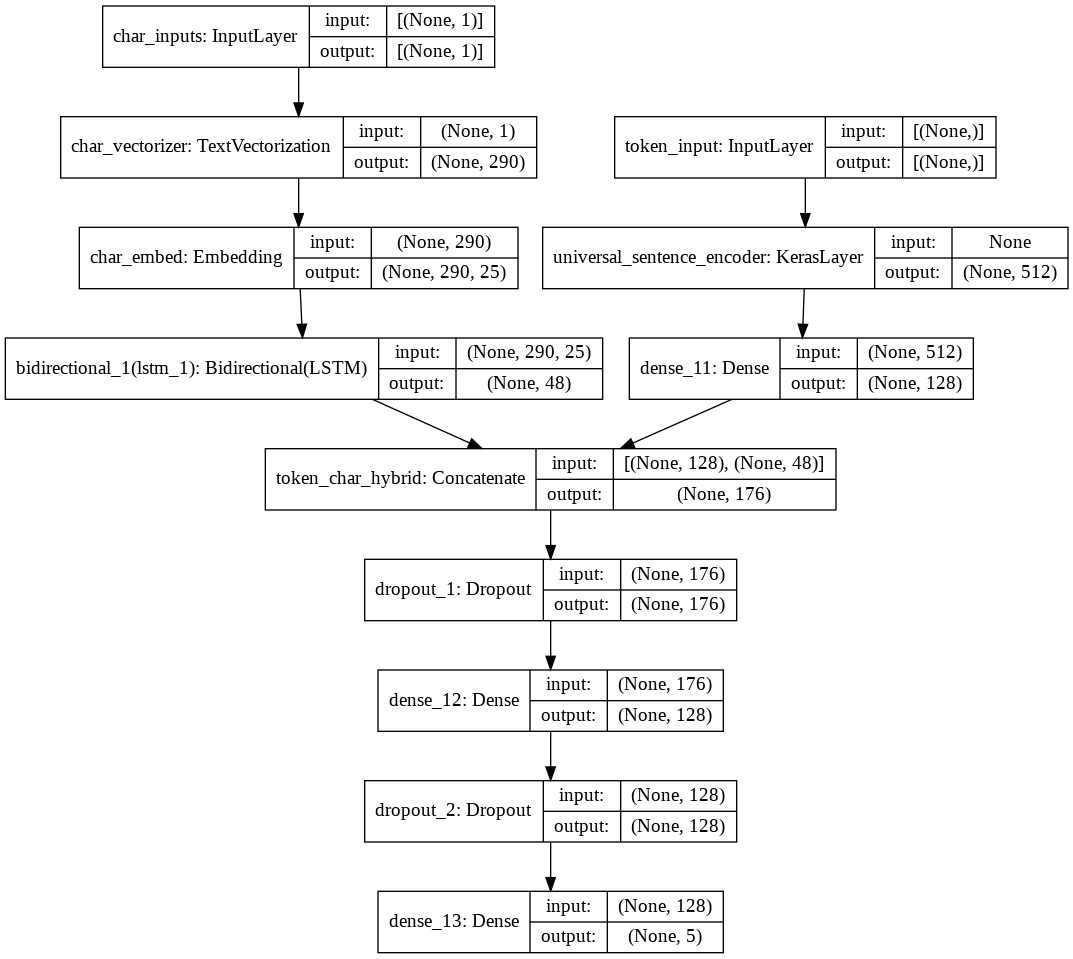

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [ ]:
model_4.compile(loss='categorical_crossentropy',
                metrics='accuracy')

### Combining token and character data into tf.Data Dataset

In [ ]:
hybrid_train_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
hybrid_train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((hybrid_train_data,hybrid_train_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
hybrid_val_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
hybrid_val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((hybrid_val_data,hybrid_val_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [ ]:
history_4 = model_4.fit(train_char_token_dataset,
                        steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                        epochs=3,
                        validation_data=val_char_token_dataset,
                        validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 194s 330ms/step - loss: 0.9853 - accuracy: 0.6036 - val_loss: 0.8012 - val_accuracy: 0.6961
Epoch 2/3
562/562 [==============================] - 193s 344ms/step - loss: 0.8154 - accuracy: 0.6842 - val_loss: 0.7206 - val_accuracy: 0.7231
Epoch 3/3
562/562 [==============================] - 186s 332ms/step - loss: 0.7872 - accuracy: 0.7008 - val_loss: 0.6934 - val_accuracy: 0.7344


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 64s 68ms/step - loss: 0.7040 - accuracy: 0.7299


[0.7040408849716187, 0.729941725730896]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.0482774e-01, 3.9632735e-01, 4.4775466e-03, 1.9014163e-01,
        4.2258184e-03],
       [2.9734579e-01, 5.3038859e-01, 1.8123275e-03, 1.6892204e-01,
        1.5312630e-03],
       [2.1791919e-01, 9.0391994e-02, 2.8106000e-02, 6.5248400e-01,
        1.1098830e-02],
       ...,
       [2.4924878e-04, 4.2124880e-03, 4.0469285e-02, 6.0358718e-05,
        9.5500869e-01],
       [8.6166505e-03, 5.0418280e-02, 2.5281101e-01, 4.4022915e-03,
        6.8375176e-01],
       [3.2766536e-01, 2.2036421e-01, 3.4744546e-01, 2.5272386e-02,
        7.9252556e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_4_results = calculate_results(val_labels_encoded,
                                    model_4_preds)
model_4_results

{'accuracy': 72.9941745001986,
 'f1': 0.7269597183736347,
 'precision': 0.7332111810319836,
 'recall': 0.7299417450019859}

## Modle 5: Transfer learning with pretrained token embeddings, character embeddings and positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Create positional embeddings

In [ ]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

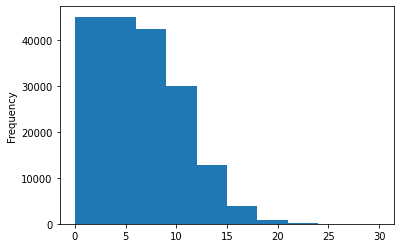

In [ ]:
train_df.line_number.plot.hist();

In [ ]:
# One hot encode line_number
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth=15)
train_line_numbers_one_hot[:15],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

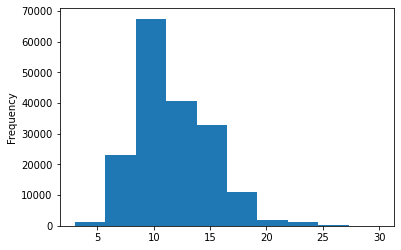

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
np.percentile(train_df.total_lines,98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_total_lines_numbers_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

In [ ]:
train_total_lines_one_hot[:15]

<tf.Tensor: shape=(15, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [ ]:
token_inputs = layers.Input(shape=[],dtype='string',name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

char_inputs = layers.Input(shape=(1,),dtype='string',name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)
ln_inputs = layers.Input(shape=(15,),dtype=tf.float32,name='line_numbers')
ln_dense = layers.Dense(32,activation='relu')(ln_inputs)
ln_model = tf.keras.Model(inputs=ln_inputs,outputs=ln_dense,name='line_numbers_model')
tl_inputs = layers.Input(shape=(20,),dtype=tf.float32,name='total_lines')
tl_dense = layers.Dense(32,activation='relu')(tl_inputs)
tl_model = tf.keras.Model(inputs=tl_inputs,outputs=tl_dense,name='total_lines_model')

In [ ]:
combined_emb = layers.Concatenate(name='char_token_hybrid')([token_model.output,
                                                             char_model.output])
x = layers.Dense(256,activation='relu')(combined_emb)
x = layers.Dropout(0.5)(x)
tri_emb = layers.Concatenate(name='char_token_position')([ln_model.output,
                                                          tl_model.output,
                                                          x])
output_layer = layers.Dense(5,activation='softmax',name='output_layer')(tri_emb)
model_5 = tf.keras.Model(inputs=[ln_model.input,
                                 tl_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name='model_5')

In [ ]:
model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
____________________________________________________________________________________________

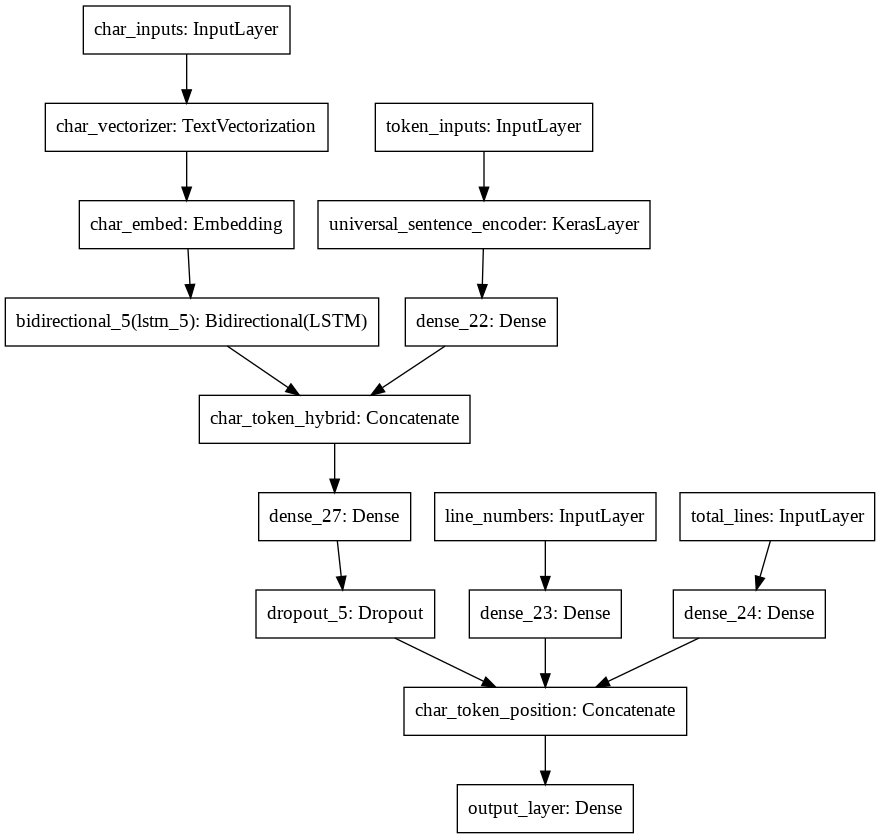

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                metrics='accuracy')

### Create datasets for model 5

In [ ]:
train_tri_data= tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                              train_total_lines_one_hot,
                                              train_sentences,
                                              train_chars))
train_tri_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tri_dataset = tf.data.Dataset.zip((train_tri_data,train_tri_labels))
train_tri_dataset = train_tri_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_tri_data= tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                              val_total_lines_one_hot,
                                              val_sentences,
                                              val_chars))
val_tri_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tri_dataset = tf.data.Dataset.zip((val_tri_data,val_tri_labels))
val_tri_dataset = val_tri_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_tri_dataset,val_tri_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [ ]:
history_5 = model_5.fit(train_tri_dataset,
                        epochs=3,
                        validation_data=val_tri_dataset,
                        steps_per_epoch=int(0.1*len(train_tri_dataset)),
                        validation_steps=int(0.1*len(val_tri_dataset)))

Epoch 1/3
562/562 [==============================] - 210s 356ms/step - loss: 1.0943 - accuracy: 0.7258 - val_loss: 0.9907 - val_accuracy: 0.7972
Epoch 2/3
562/562 [==============================] - 185s 328ms/step - loss: 0.9727 - accuracy: 0.8123 - val_loss: 0.9518 - val_accuracy: 0.8241
Epoch 3/3
562/562 [==============================] - 184s 326ms/step - loss: 0.9551 - accuracy: 0.8193 - val_loss: 0.9405 - val_accuracy: 0.8281


In [ ]:
model_5_pred_probs = model_5.predict(val_tri_dataset,verbose=1)
model_5_pred_probs

945/945 [==============================] - 80s 82ms/step


array([[0.47568294, 0.12896137, 0.01094347, 0.37032428, 0.01408792],
       [0.55253947, 0.09724527, 0.03886245, 0.30434904, 0.00700377],
       [0.27703974, 0.12551552, 0.15042876, 0.37970507, 0.06731091],
       ...,
       [0.03243753, 0.08514391, 0.03771669, 0.03158385, 0.813118  ],
       [0.03155924, 0.3027417 , 0.08639474, 0.02903465, 0.55026966],
       [0.1723567 , 0.6186727 , 0.10993449, 0.03785999, 0.06117612]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 82.5963193433073,
 'f1': 0.8248443636157304,
 'precision': 0.825467266282587,
 'recall': 0.825963193433073}

## Compare results

In [ ]:
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_hybrid_char_token_embedding':model_4_results,
                                  'model_5_pos_char_token_embedding':model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,77.323580,0.770455,0.773236,0.770047
model_2_pretrained_token_embedding,71.438501,0.715388,0.714385,0.711180
model_3_custom_char_embedding,62.154111,0.641422,0.621541,0.601924
model_4_hybrid_char_token_embedding,72.994175,0.733211,0.729942,0.726960
model_5_pos_char_token_embedding,82.596319,0.825467,0.825963,0.824844


In [ ]:
all_model_results['accuracy'] /= 100

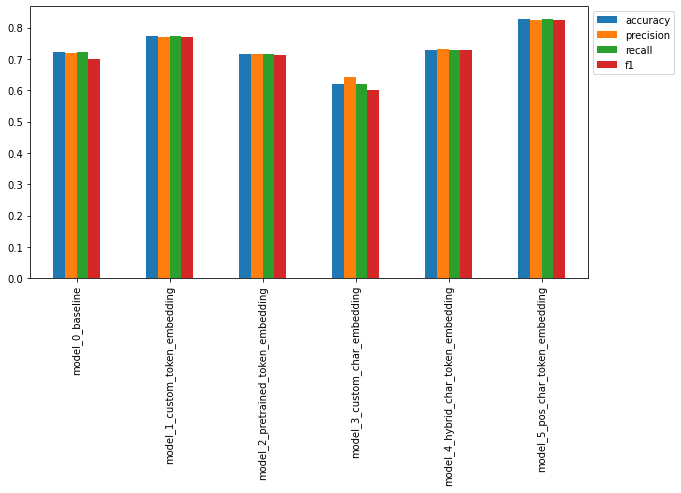

In [ ]:
all_model_results.plot(kind='bar',figsize=(10,5)).legend(bbox_to_anchor=(1.0,1.0));

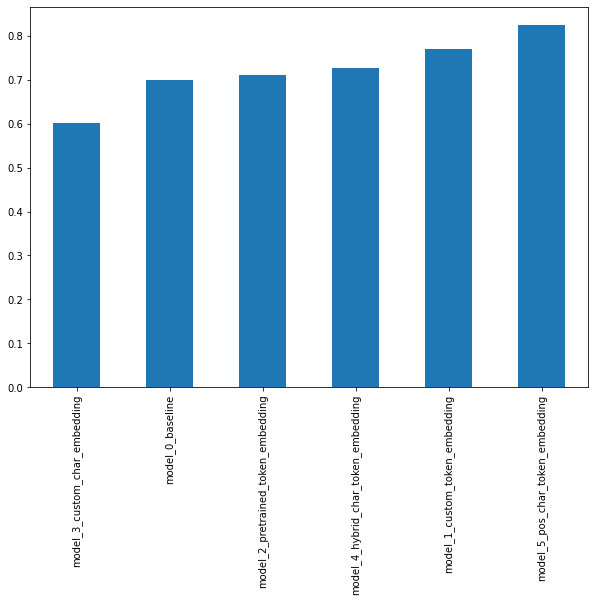

In [ ]:
all_model_results.sort_values('f1')['f1'].plot(kind='bar',figsize=(10,7));

In [ ]:
model_5.save('skimlit_tribrid_model')

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
val_tri_data= tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                              val_total_lines_one_hot,
                                              val_sentences,
                                              val_chars))
val_tri_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tri_dataset = tf.data.Dataset.zip((val_tri_data,val_tri_labels))
val_tri_dataset = val_tri_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
test_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
test_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
test_tri_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                    test_total_lines_numbers_one_hot,
                                                    test_sentences,
                                                    test_chars))
test_tri_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tri_dataset = tf.data.Dataset.zip((test_tri_data,test_tri_labels))
test_tri_dataset = test_tri_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_results = model_5.predict(test_tri_dataset)

In [ ]:
test_pred = tf.argmax(test_results,axis=1)

In [ ]:
test_scores = calculate_results(y_pred=test_pred,
                                y_true=test_labels_encoded)
test_scores

{'accuracy': 81.96781151484984,
 'f1': 0.8184512598276609,
 'precision': 0.8199265017067229,
 'recall': 0.8196781151484984}

In [ ]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_pred]
test_pred_classes

In [ ]:
test_df["pred"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_results, axis=1).numpy() 
test_df["correct"] = test_df["pred"] == test_df["target"]
test_df.head(20)

op_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

In [ ]:
wrong = test_df[test_df['correct']==False]

In [ ]:
most_wrong = wrong.sort_values('pred_prob',ascending=False)[:100]

In [ ]:
most_wrong

,target,text,line_number,total_lines,pred,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.962129,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.961801,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.951320,False
22375,RESULTS,patients were randomly assigned to receive eit...,4,12,METHODS,0.943999,False
14894,RESULTS,cox proportional hazards analysis was used to ...,4,9,METHODS,0.932477,False
...,...,...,...,...,...,...,...
6586,CONCLUSIONS,expectations of alliance and of treatment outc...,5,5,METHODS,0.859914,False
15370,RESULTS,serum creatinine was assessed centrally at ser...,4,11,METHODS,0.859586,False
418,METHODS,this study provides class i evidence that for ...,10,10,CONCLUSIONS,0.859323,False
6055,RESULTS,results will also be obtained from a series of...,6,10,METHODS,0.859165,False
